In [ ]:
!nvidia-smi

Tue Nov 10 22:14:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/meminfo |grep MemTotal

MemTotal:       26751732 kB


# Setting working directory

## Load the Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change the workding dir to: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl'`

In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl')
!ls

2.0-EDA-1.ipynb
3.0-FeatureEngineering-original.ipynb
3.1-FeatureEngineering-LagrangeInterpolate.ipynb
3.2-FeatureEngineering-From3.1-Lgrg+onehot.ipynb
3.3-FeatureEngineering-From3.2+Log1p.ipynb
3.4-FeatureEngineering.ipynb
3.5-FeatureEngineering-backToOrigin.ipynb
3.6-FeatureEngineering-brandNewScheme.ipynb
3.7-FeatureEngineering-GoBack.ipynb
4.1-Tweaking-Bayesian.ipynb
4-Tweaking.ipynb
5.1-Ensemble-Stacking.ipynb
5.2-Ensemble-Stacking-weightedKFold.ipynb
originalDataset
preprocessedData
submissionResults
Untitled
wasted


## Go to this place for original dataset: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl/originalDataset'`

# Importing libraries

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

# Loading preprocessed data

In [ ]:
x_train = pd.read_csv("preprocessedData/x_train-1110-3_7-1.csv")
x_test = pd.read_csv("preprocessedData/x_test-1110-3_7-1.csv")
y_train = pd.read_csv("preprocessedData/y_train-1110-3_7-1.csv")

In [ ]:
x_train.info

In [ ]:
x_test.info

In [ ]:
y_train.info

In [ ]:
# data_train = pd.read_csv("preprocessedData/data_train.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a.csv")

# x_train_small = pd.read_csv("preprocessedData/x_train_small.csv") #.head(200)
# x_test_small = pd.read_csv("preprocessedData/x_test_small.csv") #.head(200)
# y_train = pd.read_csv("preprocessedData/y_train.csv") #.head(200)

In [ ]:
# folds = 5
# seed = 34
# kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [ ]:
# train_x = x_train_small
# train_y = y_train
# for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
#     print('************************************ {} ************************************'.format(i+1))
#     print(train_index, valid_index)
#     trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]


# Bayesian Optimization

**Mind this**: other optimization can be used. 

Some references: 
* https://blog.csdn.net/ssswill/article/details/85274097
* https://www.cnblogs.com/PythonLearner/p/12903602.html
* https://www.kaggle.com/tilii7/bayesian-optimization-of-xgboost-parameters/notebook

In [ ]:
!pip install bayesian-optimization

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
"""定义优化函数"""
def rf_cv_xgb(gamma, min_child_weight, max_depth, 
              # reg_lambda, subsample, colsample_bytree, 
              # colsample_bylevel, eta
              ):
  
    # original HP settings
    # params = {'booster': 'gbtree',
    #                   'objective': 'binary:logistic',
    #                   'eval_metric': 'auc',
    #                   'gamma': 1,
    #                   'min_child_weight': 1.5,
    #                   'max_depth': 5,
    #                   'lambda': 10,
    #                   'subsample': 0.7,
    #                   'colsample_bytree': 0.7,
    #                   'colsample_bylevel': 0.7,
    #                   'eta': 0.04,
    #                   'tree_method': "gpu_hist", #'exact',
    #                   'seed': 2020,
    #                   'nthread': 36,
    #                   "silent": True,
    #                   }

    # 选择参数
    ## 参考这个：https://xgboost.readthedocs.io/en/latest/python/python_api.html
    model_xgb = xgb.XGBClassifier(
        booster = 'gbtree',
        objective = 'binary:logistic',
        eval_metric = 'auc',

        gamma = int(gamma), ## 注意，有的时候，有的时候该int的参数，就一定要这样int一下。
        min_child_weight = min_child_weight,
        max_depth = int(max_depth),
        reg_lambda = 10, #reg_lambda,
        subsample = 0.7, #subsample,
        colsample_bytree = 0.7, # colsample_bytree,
        colsample_bylevel = 0.7, #colsample_bylevel,
        eta = 0.04, #eta,


        tree_method = "gpu_hist",
        seed = 2020,
        nthread = 36,
        silent = True,
    )
    
    val = cross_val_score(model_xgb, x_train, y_train, cv=5, scoring='roc_auc').mean()
    
    return val

In [ ]:
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_xgb = BayesianOptimization(
    rf_cv_xgb, 
    {
        'gamma': (0.0, 2),
        'min_child_weight': (0.0, 3),
        'max_depth': (0, 10),
        # 'reg_lambda': (0, 20),
        # 'subsample': (0.0, 1),
        # 'colsample_bytree': (0.0, 1),
        # 'colsample_bylevel': (0.0, 1),
        # 'eta': (0.0, 0.2),
    }
)

"""开始优化"""
bayes_xgb.maximize(n_iter=10)

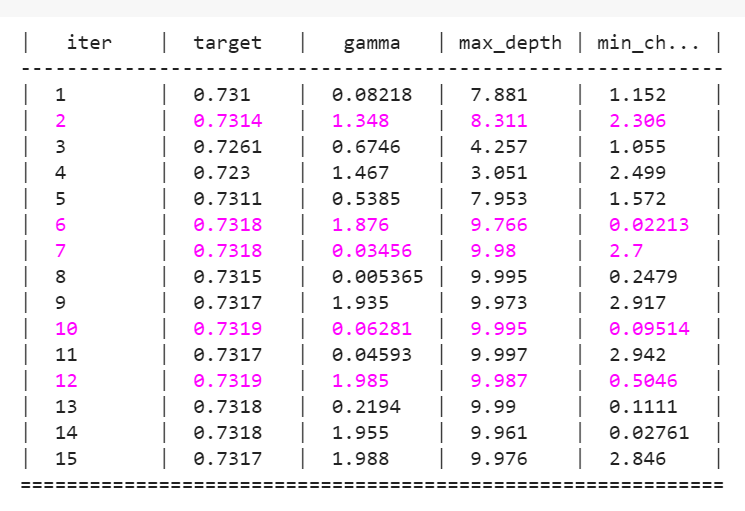

In [ ]:
def rf_cv_xgb( #gamma, min_child_weight, max_depth, 
              reg_lambda, subsample, eta, 
              # colsample_bylevel, colsample_bytree
              ):
  
    # original HP settings
    # params = {'booster': 'gbtree',
    #                   'objective': 'binary:logistic',
    #                   'eval_metric': 'auc',
    #                   'gamma': 1,
    #                   'min_child_weight': 1.5,
    #                   'max_depth': 5,
    #                   'lambda': 10,
    #                   'subsample': 0.7,
    #                   'colsample_bytree': 0.7,
    #                   'colsample_bylevel': 0.7,
    #                   'eta': 0.04,
    #                   'tree_method': "gpu_hist", #'exact',
    #                   'seed': 2020,
    #                   'nthread': 36,
    #                   "silent": True,
    #                   }

    # 选择参数
    ## 参考这个：https://xgboost.readthedocs.io/en/latest/python/python_api.html
    model_xgb = xgb.XGBClassifier(
        booster = 'gbtree',
        objective = 'binary:logistic',
        eval_metric = 'auc',

        gamma = 2, # int(gamma), ## 注意，有的时候，有的时候该int的参数，就一定要这样int一下。
        min_child_weight = 0.5, #min_child_weight,
        max_depth = 10, # int(max_depth),
        reg_lambda = reg_lambda,
        subsample = subsample,
        eta = eta, 
        colsample_bytree = 0.7, # colsample_bytree,
        colsample_bylevel = 0.7, #colsample_bylevel,


        tree_method = "gpu_hist",
        seed = 2020,
        nthread = 36,
        silent = True,
    )
    
    val = cross_val_score(model_xgb, x_train, y_train, cv=5, scoring='roc_auc').mean()
    
    return val

bayes_xgb = BayesianOptimization(
    rf_cv_xgb, 
    {
        # 'gamma': (0.0, 2),
        # 'min_child_weight': (0.0, 3),
        # 'max_depth': (0, 10),
        'reg_lambda': (0, 20),
        'subsample': (0.0, 1),
        'eta': (0.0, 0.2),
        # 'colsample_bytree': (0.0, 1),
        # 'colsample_bylevel': (0.0, 1),
    }
)

"""开始优化"""
bayes_xgb.maximize(n_iter=10)

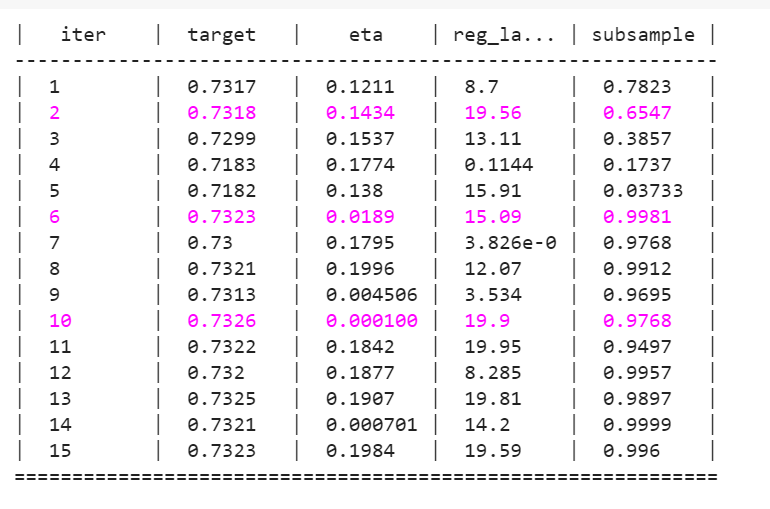

In [ ]:
def rf_cv_xgb( #gamma, min_child_weight, max_depth, 
              # reg_lambda, subsample, eta, 
              colsample_bylevel, colsample_bytree
              ):
  
    # original HP settings
    # params = {'booster': 'gbtree',
    #                   'objective': 'binary:logistic',
    #                   'eval_metric': 'auc',
    #                   'gamma': 1,
    #                   'min_child_weight': 1.5,
    #                   'max_depth': 5,
    #                   'lambda': 10,
    #                   'subsample': 0.7,
    #                   'colsample_bytree': 0.7,
    #                   'colsample_bylevel': 0.7,
    #                   'eta': 0.04,
    #                   'tree_method': "gpu_hist", #'exact',
    #                   'seed': 2020,
    #                   'nthread': 36,
    #                   "silent": True,
    #                   }

    # 选择参数
    ## 参考这个：https://xgboost.readthedocs.io/en/latest/python/python_api.html
    model_xgb = xgb.XGBClassifier(
        booster = 'gbtree',
        objective = 'binary:logistic',
        eval_metric = 'auc',

        gamma = 2, # int(gamma), ## 注意，有的时候，有的时候该int的参数，就一定要这样int一下。
        min_child_weight = 0.5, #min_child_weight,
        max_depth = 10, # int(max_depth),
        reg_lambda = 20, #reg_lambda,
        subsample = 0.9768, # subsample,
        eta = 0.0001, # eta, 
        colsample_bytree = colsample_bytree,
        colsample_bylevel = colsample_bylevel,


        tree_method = "gpu_hist",
        seed = 2020,
        nthread = 36,
        silent = True,
    )
    
    val = cross_val_score(model_xgb, x_train, y_train, cv=5, scoring='roc_auc').mean()
    
    return val

bayes_xgb = BayesianOptimization(
    rf_cv_xgb, 
    {
        # 'gamma': (0.0, 2),
        # 'min_child_weight': (0.0, 3),
        # 'max_depth': (0, 10),
        # 'reg_lambda': (0, 20),
        # 'subsample': (0.0, 1),
        # 'eta': (0.0, 0.2),
        'colsample_bytree': (0.0, 1),
        'colsample_bylevel': (0.0, 1),
    }
)

"""开始优化"""
bayes_xgb.maximize(n_iter=10)

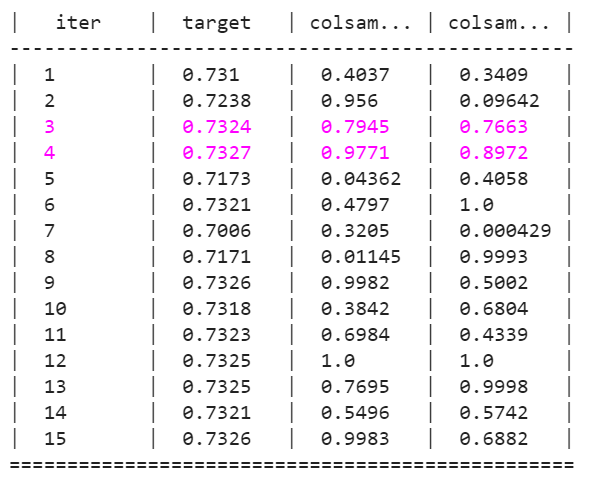

# -----(Don't run later part, generally speaking)--------

# Greedy search

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_best_cv_params_xgb(gamma = 1, min_child_weight = 1.5, max_depth = 5, 
                    reg_lambda = 10, subsample = 0.7, colsample_bytree = 0.7, 
                    colsample_bylevel = 0.7, eta = 0.04,
                       param_grid=None):
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
    
    model_xgb = xgb.XGBClassifier(
        booster = 'gbtree',
        objective = 'binary:logistic',
        eval_metric = 'auc',

        gamma = gamma, ## 注意，有的时候，有的时候该int的参数，就一定要这样int一下。
        min_child_weight = min_child_weight,
        max_depth = max_depth,
        reg_lambda = reg_lambda,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        colsample_bylevel = colsample_bylevel,
        eta = eta,


        tree_method = "gpu_hist", #'exact', # 
        seed = 2020,
        nthread = 36,
        silent = True,
    )

    grid_search = GridSearchCV(estimator=model_xgb, 
                               cv=cv_fold,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               verbose = 2,
                              #  n_jobs = 2
                              )
    grid_search.fit(x_train, y_train)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))

In [ ]:
# params = {'booster': 'gbtree',
#                   'objective': 'binary:logistic',
#                   'eval_metric': 'auc',
#                   'gamma': 1,
#                   'min_child_weight': 1.5,
#                   'max_depth': 5,
#                   'lambda': 10,
#                   'subsample': 0.7,
#                   'colsample_bytree': 0.7,
#                   'colsample_bylevel': 0.7,
#                   'eta': 0.04,
#                   'tree_method': "gpu_hist", #'exact',
#                   'seed': 2020,
#                   'nthread': 36,
#                   "silent": True,
#                   }

In [ ]:
xgb_params = {
    'gamma': [i * 0.2 for i in range(0, 10 + 1)], 
    "min_child_weight": [i * 0.5 for i in range(0, 4 + 1)]
}

get_best_cv_params_xgb(gamma = None, min_child_weight = 1.5, max_depth = 5, 
                    reg_lambda = 10, subsample = 0.7, colsample_bytree = 0.7, 
                    colsample_bylevel = 0.7, eta = 0.04,
                            param_grid=xgb_params)

* 模型当前最优参数为:{'gamma': 1.0, 'min_child_weight': 0.0}
* 模型当前最优得分为:0.7285129387837725

In [ ]:
xgb_params = {
    'max_depth': range(3, 8), 
    "reg_lambda": range(0, 20, 5)
}

get_best_cv_params_xgb(gamma = 1, min_child_weight = 0, max_depth = None, 
                    reg_lambda = None, subsample = 0.7, colsample_bytree = 0.7, 
                    colsample_bylevel = 0.7, eta = 0.04,
                            param_grid=xgb_params)

* 模型当前最优参数为:{'max_depth': 7, 'reg_lambda': 10}
* 模型当前最优得分为:0.7311631311823202

In [ ]:
xgb_params = {
    'subsample': [i * 0.1 for i in range(1, 9 + 1)], # [0.1], #
    # "colsample_bytree": [i * 0.1 for i in range(1, 9 + 1)], 
    # 'colsample_bylevel': [i * 0.1 for i in range(1, 9 + 1)], 
    "eta": [i * 0.005 for i in range(4, 12 + 1)] # [0.01] # 
}

get_best_cv_params_xgb(gamma = 1, min_child_weight = 0, max_depth = 7, 
                    reg_lambda = 10, subsample = 0.7, colsample_bytree = 0.7, 
                    colsample_bylevel = 0.7, eta = 0.04,
                            param_grid=xgb_params)

* 模型当前最优参数为:{'eta': 0.06, 'subsample': 0.9}
* 模型当前最优得分为:0.7280618319887984

In [ ]:
xgb_params = {
    'subsample': [0.85 + i * 0.01 for i in range(0, 10 + 1)], # [0.1], #
    "eta": [0.06 + i * 0.01 for i in range(0, 5 + 1)] # [0.01] # 
}

get_best_cv_params_xgb(gamma = 1, min_child_weight = 0, max_depth = 7, 
                    reg_lambda = 10, subsample = 0.7, colsample_bytree = 0.7, 
                    colsample_bylevel = 0.7, eta = 0.04,
                            param_grid=xgb_params)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
[CV] eta=0.06, subsample=0.85 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... eta=0.06, subsample=0.85, total=   4.3s
[CV] eta=0.06, subsample=0.85 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] ......................... eta=0.06, subsample=0.85, total=   4.9s
[CV] eta=0.06, subsample=0.85 ........................................
[CV] ......................... eta=0.06, subsample=0.85, total=   5.1s
[CV] eta=0.06, subsample=0.85 ........................................
[CV] ......................... eta=0.06, subsample=0.85, total=   4.4s
[CV] eta=0.06, subsample=0.85 ........................................
[CV] ......................... eta=0.06, subsample=0.85, total=   4.3s
[CV] eta=0.06, subsample=0.86 ........................................
[CV] ......................... eta=0.06, subsample=0.86, total=   4.3s
[CV] eta=0.06, subsample=0.86 ........................................
[CV] ......................... eta=0.06, subsample=0.86, total=   4.9s
[CV] eta=0.06, subsample=0.86 ........................................
[CV] ......................... eta=0.06, subsample=0.86, total=   5.1s
[CV] eta=0.06, subsample=0.86 ........................................
[CV] .

In [ ]:
xgb_params = {
    # 'subsample': [i * 0.1 for i in range(1, 9 + 1)], 
    # "eta":  [i * 0.005 for i in range(1, 20 + 1)], 
    "colsample_bytree": [i * 0.1 for i in range(1, 9 + 1)], 
    'colsample_bylevel': [i * 0.1 for i in range(1, 9 + 1)], 
}

get_best_cv_params_xgb(gamma = 1, min_child_weight = 0, max_depth = 7, 
                    reg_lambda = 10, subsample = 0.7, colsample_bytree = 0.7, 
                    colsample_bylevel = 0.7, eta = 0.04,
                            param_grid=xgb_params)

In [ ]:
# # from sklearn.model_selection import GridSearchCV

# def get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0, 
#                        feature_fraction=1.0, bagging_freq=0, min_data_in_leaf=20, min_child_weight=0.001, 
#                        min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=None):
#     # 设置5折交叉验证
#     cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, verbose)
    
#     model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
#                                    n_estimators=n_estimators,
#                                    num_leaves=num_leaves,
#                                    max_depth=max_depth,
#                                    bagging_fraction=bagging_fraction,
#                                    feature_fraction=feature_fraction,
#                                    bagging_freq=bagging_freq,
#                                    min_data_in_leaf=min_data_in_leaf,
#                                    min_child_weight=min_child_weight,
#                                    min_split_gain=min_split_gain,
#                                    reg_lambda=reg_lambda,
#                                    reg_alpha=reg_alpha,
#                                    n_jobs= 8
#                                   )
#     grid_search = GridSearchCV(estimator=model_lgb, 
#                                cv=cv_fold,
#                                param_grid=param_grid,
#                                scoring='roc_auc'
#                               )
#     grid_search.fit(x_train, y_train)

#     print('模型当前最优参数为:{}'.format(grid_search.best_params_))
#     print('模型当前最优得分为:{}'.format(grid_search.best_score_))

In [ ]:
# lgb_params = {'num_leaves': range(10, 80, 5), 'max_depth': range(3,10,2)}
# get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=None, max_depth=None, min_data_in_leaf=20, 
#                    min_child_weight=0.001,bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, 
#                    min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)